# This notebook contains the code for Task 2 for the General Dataset

# Project Setup

Doing the necessary installation of the libraries

In [ ]:
!pip install lightgbm
!pip install coral_pytorch
!pip install catboost
!pip install deslib
!pip install hyperopt
!pip install git+https://github.com/hyperopt/hyperopt-sklearn
!wget  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl
!apt install libomp-dev
!pip install faiss

# !pip install rgf_python
# !pip install --ignore-installed --upgrade tensorflow==2.4.1
# !pip install --force-reinstall --no-deps git+https://github.com/ck37/coral-ordinal/
# !pip install pygam
# !apt install libomp-dev
# !pip install faiss-gpu

     |████████████████████████████████| 76.1 MB 71 kB/s 
     |████████████████████████████████| 158 kB 5.5 MB/s 
  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-9hn4etcd
  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-9hn4etcd
     |████████████████████████████████| 154 kB 5.2 MB/s 
  Created wheel for hpsklearn: filename=hpsklearn-0.0.3-py3-none-any.whl size=27011 sha256=7382aef939e10c6b6954c2706379d3447624e2d64e0f62f76d866525f0e2b30c
  Stored in directory: /tmp/pip-ephem-wheel-cache-11s7vvkp/wheels/4b/06/53/c35e360ca94aa0ab93518bf53abe5fb270c95dbe56b8e2e76b
Successfully built hpsklearn
--2022-03-21 18:32:09--  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5c18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting 

Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numpy import mean
from numpy import std
from numpy import arange
from numpy import save

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix
import seaborn as sn

from scipy.stats import kendalltau
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from hpsklearn import HyperoptEstimator
import faiss

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from deslib.dcs import OLA
from deslib.dcs import MCB
from deslib.des import DESP
from deslib.des import KNORAE
from deslib.des import KNORAU
from deslib.des import METADES
from deslib.des.des_mi import DESMI
from deslib.static import StackedClassifier

from imblearn.over_sampling import SMOTE,BorderlineSMOTE


# from sklearn.base import clone
# from pygam import LogisticGAM, LinearGAM
# import coral_ordinal as coral
# from tensorflow.keras.utils import to_categorical

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gen_industry_df = pd.read_excel(r'/content/drive/MyDrive/AI Case Study Data/general_industries_df_case_competition_scrambled_train.xlsx', sheet_name='Data')

# Data Preparation

Following tasks have been completed here:

1.   Feature Engineering
2.   Train Test Split
3.   Scaling features
4.   Imputing missing values
5.   Removing outliers
6.   Oversampling to balance classes



### Define functions for creating of new features ( Each function has a comment for its explaination)

In [ ]:
# 3 year averages function for each metric
def three_year_average(X, col_y0, col_y1, col_y2, col):
    X.drop(X[X[col_y0].isnull()].index, inplace = True)
    
    X[col] = X[col_y0]
    
    two_years_average = X[col_y1].notnull() & X[col_y2].isnull()
    X.loc[two_years_average, col] = X.loc[two_years_average, col_y0] * 4/7 + X.loc[two_years_average, col_y1] * 3/7
    
    three_years_average = X[col_y1].notnull() & X[col_y2].notnull()
    X.loc[three_years_average, col] = X.loc[three_years_average, col_y0] * 4/9 + X.loc[three_years_average, col_y1] * 3/9 + X.loc[three_years_average, col_y2] * 2/9
    
    return X

# feature engineering fucntion (called later after imputer)
def feat_eng(data_left):
  for i in range(4):
    data_left['DEBT2EBITDA_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['EBITDA_Y' + str(i)]
    data_left['DEBT2CAPT_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['CAPITALIZATION_Y' + str(i)]
    data_left['DEBT2EQUITY_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALEQUITY_Y' + str(i)]
    data_left['DEBT2ASSET_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['DEBT2TANGIBLENW_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['tangibleNetWorth_Y' + str(i)]
    data_left['CASH2ASSET_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['CASH2DEBT_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALDEBT_Y' + str(i)]
    data_left['CA2CL_Y'+str(i)] = data_left['CURRENTASSET_Y'+str(i)] / data_left['CURRENTLIABILITY_Y' + str(i)]

    # Quick (acid-test) ratio = (cash + short term investments + net current recievables ) / current liabilities
    # CCE = cash + short term investments, ARTurnover ~ net current recievables
    data_left['ACIDTESTRATIO_Y'+str(i)] = (data_left['CCE_Y'+str(i)] + data_left['ARTurnover_Y'+str(i)])/ data_left['CURRENTLIABILITY_Y' + str(i)]

    # Inventory Turnover = 365/ inventory days
    data_left['INVENTORYTURNOVER_Y'+str(i)] = 365 / data_left['INVENTORYDAYS_Y' + str(i)]
    # Cost of Goods Sold = Inventory Turnover * Average Inventory
    if 'INVENTORY_Y0' in data_left:
      data_left['COGS_Y'+str(i)] = data_left['INVENTORYTURNOVER_Y' + str(i)] * data_left['INVENTORY_Y' + str(i)]
    else:
      data_left['COGS_Y'+str(i)] = data_left['INVENTORYTURNOVER_Y' + str(i)] * data_left['Inventory_Y' + str(i)]

    
    # Cash Conversion Cycle = Inventory Days + Recievable Days - Payable Days
    data_left['CCC_Y'+str(i)] = data_left['INVENTORYDAYS_Y' + str(i)] + data_left['receivabledays_Y' + str(i)] - data_left['payableDAYS_Y' + str(i)]

    # Times Intrest Earned Ratio = operating income/ intrest expense
    # operating profit = operating income - operating expenses (do not have op expenses)
    data_left['TIERATIO_Y'+str(i)] = data_left['OPERPROFIT_Y'+str(i)] / data_left['TOTINTEXP_Y' + str(i)]

    # Return on Assets Ratio = net income / average total assets
    # net income = net profit
    data_left['ROARATIO_Y'+str(i)] = data_left['NETPROFIT_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]

    # Enterprise Value = debt + equity - cash
    data_left['EnterpriseValue_Y'+str(i)] = data_left['TOTALDEBT_Y' + str(i)] + data_left['TOTALEQUITY_Y' + str(i)] - data_left['CCE_Y' + str(i)]

    # Retention ratio = retained earnings/ net income
    # net income = net profit
    data_left['RetentionRATIO_Y'+str(i)] = data_left['RETAINED_EARNINGS_Y'+str(i)] / data_left['NETPROFIT_Y'+str(i)] 

  for i in range(3):
    data_left['DEBT2FCF_Y'+str(i)] = data_left['TOTALDEBT_Y' + str(i)] / data_left['FCF_Y'+str(i)]

  data_left['TotalAssetBINS'] = pd.qcut(data_left['TOTALASSET_3YearAverage'], 4, labels=[1,2,3,4]).astype(int)

  relevant_feat = ['TOTALREVENUE_Y', 'CAPITALIZATION_Y', 'TOTALDEBT_Y', 'TOTALASSET_Y', 'NETSALES_Y', 'EBITDA_Y', 'CURRENTASSET_Y', 'FIXEDASSET_Y',
                   'CURRENTLIABILITY_Y', 'NONCURRLIA_Y', 'TOTALEQUITY_Y', 'TOTALNETWORTH_Y', 'TOTINTEXP_Y', 'LEASERENTEXP_Y', 'EBITDAR_Y', 'receivabledays_Y',
                   'INVENTORYDAYS_Y', 'payableDAYS_Y', 'tangibleNetWorth_Y', 'FIXEDCHARGECOV_Y', 'DEBTSERVCOV_Y', 'NETPROFIT_Y',
                   'OPERPROFIT_Y', 'ARTurnover_Y', 'RETAINED_EARNINGS_Y',  'CCE_Y']
  for feat in relevant_feat:
    data_left[feat+'OYGrowth'] = 0

    maskY2 = data_left[feat+str(2)].isnull() & data_left[feat+str(1)].notnull()
    data_left.loc[maskY2, feat+'OYGrowth'] += (data_left.loc[maskY2, feat+str(0)] - data_left.loc[maskY2, feat+str(1)])/data_left.loc[maskY2, feat+str(1)]

    maskY3 = data_left[feat+str(3)].isnull() & data_left[feat+str(2)].notnull()
    data_left.loc[maskY3, feat+'OYGrowth'] += (data_left.loc[maskY3, feat+str(0)] - data_left.loc[maskY3, feat+str(1)])/data_left.loc[maskY3, feat+str(1)]
    data_left.loc[maskY3, feat+'OYGrowth'] += (data_left.loc[maskY3, feat+str(1)] - data_left.loc[maskY3, feat+str(2)])/data_left.loc[maskY3, feat+str(2)]
    data_left.loc[maskY3, feat+'OYGrowth'] = data_left.loc[maskY3, feat+'OYGrowth']/2

    maskAllY = data_left[feat+str(3)].notnull()
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(0)] - data_left.loc[maskAllY, feat+str(1)])/data_left.loc[maskAllY, feat+str(1)]
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(1)] - data_left.loc[maskAllY, feat+str(2)])/data_left.loc[maskAllY, feat+str(2)]
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(2)] - data_left.loc[maskAllY, feat+str(3)])/data_left.loc[maskAllY, feat+str(3)]
    data_left.loc[maskAllY, feat+'OYGrowth'] = data_left.loc[maskAllY, feat+'OYGrowth']/3

  return data_left


# outlier removal function based on z-scores
def remove_outlier(data):
    cols = ['ROW', 'Period', 'B_PLUS_FLAG', 'Final_IG', 'BR Code']
    c = []
    for col in data.columns:
        if col not in cols:
            c.append(col)
    for col in c:
        col_zscore = col + '_zscore'
        data[col_zscore] = (data[col] - data[col].mean())/data[col].std(ddof=0)
    data['outlier'] = 'N'
    for index, row in data.iterrows():
        for c in data.columns:
            if 'zscore' in c:
                if abs(row[c]) > 3:
                    data.loc[index, 'outlier'] = 'Y'
                    break
    finaldf = data[data.outlier == 'N']
    cols = []
    for c in data.columns:
        if 'zscore' not in c and c != 'outlier':
            cols.append(c)
    finaldf = finaldf[cols]
    return finaldf

#outlier removal function based on Inter-quartile range
def remove_outlier2(d):
    cols = ['ROW', 'Period', 'B_PLUS_FLAG', 'Final_IG', 'BR Code']    
    c = []
    for col in d.columns:
        if col not in cols:
            c.append(col)
    d['outlier'] = 'N'
    for index, row in d.iterrows():
        print(index)
        for col in c:
            q1 = d[col].quantile(0.25)
            q3 = d[col].quantile(0.75)
            iqr = q3-q1
            if (row[col] >= (q3 + 1.5*iqr)) | (row[col] <= (q1 - 1.5*iqr)) :
                d.loc[index, 'outlier'] = 'Y'
                break
    finaldf = d[d.outlier == 'N']
    cols = []
    for c in d.columns:
        if c != 'outlier':
            cols.append(c)
    finaldf = finaldf[cols]
    return finaldf

### Feature Engineering



*   Remove rows with no Y0 values
*   Replace infinite values
*   Add engineered features



In [ ]:
# sort dataframe
gen_industry_df = gen_industry_df.sort_values(by = ['ROW'], ascending=False)

# extract financial feature names
non_fin_features = ['ROW', 'Corp_Residence_Country_Code', 'BR Code', 'Period', 'CUSTOMER_ID', 'Final_IG', 'B_PLUS_FLAG']
fin_features = np.sort(list(set(gen_industry_df.columns) - set(non_fin_features)))

# add 3-year averages, and remove rows missing y0 data
cols_to_avg = []

for col in fin_features:
    if (col.endswith('Y0') and not col.endswith('growth_Y0')):
        cols_to_avg.append([col, col[:-2] + 'Y1', col[:-2] + 'Y2', col[:-2] + '3YearAverage'])

data_left = gen_industry_df.copy()
for col0, col1, col2, col in cols_to_avg:
    orig_num_data = len(data_left)
    data_left = three_year_average(data_left, col0, col1, col2, col)
    remaining_data = len(data_left)
    #print((orig_num_data - remaining_data), 'data records are dropped due to ' + col + '\n')

# reset index
data_left = data_left.reset_index(drop = True)

# reset financial features variable to include 3-year avgs
fin_features = np.sort(list(set(data_left.columns) - set(non_fin_features)))

# replace infinite values
for col in fin_features:  
  data_left.loc[data_left[col] == -np.inf, col] = data_left.loc[(data_left[col]> -np.inf)&(data_left[col]< np.inf),col].min()
  data_left.loc[data_left[col] == np.inf, col] = data_left.loc[(data_left[col]> -np.inf)&(data_left[col]< np.inf),col].max()

# add engineered features
data_left = feat_eng(data_left)

# recompute list of financial features
fin_features = np.sort(list(set(data_left.columns) - set(non_fin_features)))

### Create Train Test Split

*    Stratify on target
*    Take just financial features for X

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data_left.drop(['Final_IG', 'B_PLUS_FLAG'], axis=1), data_left[['Final_IG']], test_size=0.25, random_state=42, stratify=data_left[['Final_IG']])

# take just the financial features
X_train = X_train[fin_features]
X_test = X_test[fin_features]

### Scale Features

*    using Standard Scalar

In [ ]:
# scale features
scaler_train = StandardScaler()
scaler_trained = scaler_train.fit(X_train)
X_train_scaled = scaler_trained.transform(X_train)
X_test_scaled = scaler_trained.transform(X_test)

### Impute Missing Values


*   Using Iterative Imputer



In [ ]:
choice = "load" # options: train, load
# use train if you want to compute the imputed values
if choice == "train":
  # create imputer model to impute missing values, based on training data
  imputer_train = IterativeImputer(max_iter = 3, estimator = ExtraTreesRegressor(n_estimators=10, random_state=42, max_depth=5, min_samples_leaf=10))
  imputer_train.fit(X_train_scaled)
  X_Imputed_Train = imputer_train.transform(X_train_scaled)

  # Use same imputer to impute missing values for testing data
  X_Imputed_Test = imputer_train.transform(X_test_scaled)

  # save to files, to easily access 
  save('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Train.npy', X_Imputed_Train)
  save('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Test.npy', X_Imputed_Test)
# use load if you want to obtain the values from google drive if already saved once
else:
  # once imputer is run once, just load output from drive
  X_Imputed_Test = np.load('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Test.npy')
  X_Imputed_Train = np.load('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Train.npy')

In [ ]:
# change 1 row from y_test with label 15, to 16 to have at least one row for target 16
for index, row in y_test.loc[y_test['Final_IG']==15].iterrows():
  y_test.loc[index,'Final_IG']=16
  break

# change 3 rows from y_train label 15, to 16 to have at least 3 rows for target 16 (needed for oversampling)
count = 0
for index, row in y_train.loc[y_train['Final_IG']==15].iterrows():
  if count>=3:
    break
  y_train.loc[index,'Final_IG']=16
  count+=1

### Oversampling to balance classes

In [ ]:
sm = BorderlineSMOTE(random_state = 42, k_neighbors=2)
X_train_resampled, y_train_resampled = sm.fit_resample(X_Imputed_Train, np.array(y_train['Final_IG']))

### Outlier Removal

In [ ]:
# original version
lof = LocalOutlierFactor(n_neighbors = 5, contamination = 0.02)
yhat = lof.fit_predict(X_train_resampled)
mask = yhat != -1
X_train_resampled, y_train_resampled = X_train_resampled[mask], y_train_resampled[mask]

# Hyperparameter Tuning

The hyperparamter search space has been defined for each of the individual models. The range of each hyperparameter has been specified

In [ ]:
space_XGBoost={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 42
    }
space_LGBM = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'gamma': hp.quniform('gamma', 0.1, 0.5, 0.1),
    'num_leaves': hp.quniform('num_leaves', 30, 50, 1),
    'reg_alpha': hp.quniform('reg_alpha', 1.1, 1.5, 0.1),
    'reg_lambda': hp.uniform('reg_lambda', 1.1, 1.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.5),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),

}
# space_RGF = {
#     'max_leaf': hp.quniform('max_leaf', 1000, 6000, 200),
#     'algorithm': hp.choice('algorithm', ['RGF', 'RGF_Opt', 'RGF_Sib']),
#     'l2': hp.choice('l2', [1, 0.1, 0.01]),
#     'n_tree_search': hp.quniform('n_tree_search', 1, 10, 1)
# }
space_CatBoost = {
     'iterations': hp.quniform('iterations', 10, 1000, 10),
     'depth' : hp.quniform('depth', 1, 8, 1),
     'learning_rate': hp.loguniform('learning_rate', -4, -1),
     'random_strength': hp.loguniform('random_strength', 1e-9, 10),
     'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 1.0),
     'border_count': hp.quniform('border_count', 1, 255, 5),
     'l2_leaf_reg': hp.quniform('l2_leaf_reg', 2, 30, 2),
     'scale_pos_weight': hp.uniform('scale_pos_weight', 0.01, 1.0)
 }

In [ ]:
#Defining the XGBoost classifier
def objective_XGBoost(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_Imputed_Train, np.array(y_train).ravel()), ( X_Imputed_Test, np.array(y_test).ravel())]
    
    clf.fit(X_Imputed_Train, np.array(y_train).ravel(),
            eval_set=evaluation, eval_metric="mlogloss",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict_proba(X_Imputed_Test)
    log_loss_calc = log_loss(np.array(y_test).ravel(), pred)
    print ("SCORE:", log_loss_calc)
    return {'loss': log_loss_calc, 'status': STATUS_OK }
#Defining the LGBM classifier
def objective_LGBM(space):
  clf = LGBMClassifier(n_estimators=int(space['n_estimators']),
                         max_depth = int(space['max_depth']),
                         learning_rate=space['learning_rate'],
                         gamma = space['gamma'],
                         num_leaves = int(space['num_leaves']),
                         reg_alpha= space['reg_alpha'],
                         reg_lambda= space['reg_lambda'],
                         colsample_bytree= space['colsample_bytree'],
                         min_child_weight= space['min_child_weight'])
  evaluation = [( X_Imputed_Train, np.array(y_train).ravel()), ( X_Imputed_Test, np.array(y_test).ravel())]
  clf.fit(X_Imputed_Train, np.array(y_train).ravel(), eval_set=evaluation, eval_metric="multi_logloss",verbose=False)
  pred = clf.predict_proba(X_Imputed_Test)
  log_loss_calc = log_loss(np.array(y_test).ravel(), pred)
  print ("SCORE:", log_loss_calc)
  return {'loss': log_loss_calc, 'status': STATUS_OK }

# def objective_RGF(space):
#   clf = RGFClassifier(
#       max_leaf = int(space['max_leaf']),
#       algorithm = space['algorithm'],
#       loss = 'Log',
#       l2 = float(space['l2']),
#       n_tree_search = int(space['n_tree_search'])
#   )

#   log_loss_calc = cross_val_score(clf, X_Imputed_Train, np.array(y_train).ravel(), cv = 2, scoring = 'neg_log_loss', n_jobs = -1).mean()
#   return {'loss': log_loss_calc, 'status': STATUS_OK }


#Defining the Catboost Classifier
weights = [1,0.5,1.2,1.5,2,3,3,3,3,2,1.5,1.2,1.1,1.08,1,1,0.5,1.08]
def objective_CatBoost(space):
  clf = CatBoostClassifier(
      iterations = int(space['iterations']),
      depth = int(space['depth']),
      learning_rate = space['learning_rate'],
      random_strength = space['random_strength'],
      bagging_temperature = space['bagging_temperature'],
      border_count = int(space['border_count']),
      l2_leaf_reg = int(space['l2_leaf_reg']),
      class_weights = weights 
  )
  evaluation = [( X_Imputed_Train, np.array(y_train).ravel()), ( X_Imputed_Test, np.array(y_test).ravel())]
  clf.fit(X_Imputed_Train, np.array(y_train).ravel(), eval_set=evaluation, verbose=False)
  pred = clf.predict_proba(X_Imputed_Test)
  log_loss_calc = log_loss(np.array(y_test).ravel(), pred)
  print ("SCORE:", log_loss_calc)
  return {'loss': log_loss_calc, 'status': STATUS_OK }

### Hyperparameter tuning for XGBoost

In [ ]:
# Hyperparameter tuning for XGBoost
trials = Trials()

best_hyperparams_XGBoost = fmin(fn = objective_XGBoost,
                        space = space_XGBoost,
                        algo = tpe.suggest,
                        max_evals = 60, trials = trials)

SCORE:
1.9794154234307917
SCORE:
2.0429858821151425
SCORE:
2.021203713858521
SCORE:
1.9720199577074484
SCORE:
1.984614715781263
SCORE:
2.0052646193235804
SCORE:
1.945553833547133
SCORE:
1.9859637393311809
SCORE:
1.9825796809747438
SCORE:
2.018840212041571
SCORE:
1.9452202181379847
SCORE:
2.025292317202905
SCORE:
1.9989347453975104
SCORE:
1.9440162061493493
SCORE:
2.05256705675617
SCORE:
2.0135514979938653
SCORE:
2.0348227960458973
SCORE:
1.99197999842727
SCORE:
1.9573431639087338
SCORE:
1.9568734346179986
SCORE:
1.9324111762389211
SCORE:
1.9361787345406352
SCORE:
1.9317002650469146
SCORE:
1.9318351791229582
SCORE:
1.9528683648205898
SCORE:
1.9331712902015907
SCORE:
1.9621890738228969
SCORE:
1.9744477060207453
SCORE:
1.968277732596407
SCORE:
2.0014753074013343
SCORE:
1.9527939420396434
SCORE:
2.038062527767617
SCORE:
1.981795223571356
SCORE:
1.9966066667936704
SCORE:
1.9612739199559632
SCORE:
1.9385018094285102
SCORE:
1.9547990184241313
SCORE:
1.9945218773602527
SCORE:
1.935473312396526

In [ ]:
# add constant hyperparameters
best_hyperparams_XGBoost["n_estimators"] = 50
best_hyperparams_XGBoost["eta"] = 0.001
best_hyperparams_XGBoost["subsample"] = 1.0

In [ ]:
# Best Hyperparameters for XGBoost
best_hyperparams_XGBoost

{'colsample_bytree': 0.7924098400793136,
 'gamma': 4.965400030515824,
 'max_depth': 14.0,
 'min_child_weight': 0.0,
 'reg_alpha': 40.0,
 'reg_lambda': 0.7173099655368509}

### Hyperparameter tuning for LGBM

In [ ]:
# Hyperparameter tuning for LGBM
trials = Trials()

best_hyperparams_LGBM = fmin(fn = objective_LGBM,
                        space = space_LGBM,
                        algo = tpe.suggest,
                        max_evals = 60, trials = trials)

SCORE:
1.6630074256819858
SCORE:
1.7021710972549913
SCORE:
1.7409021511353902
SCORE:
1.7055264061867124
SCORE:
1.671470179462971
SCORE:
1.6671284714422128
SCORE:
1.7363596547813709
SCORE:
1.6514888994647472
SCORE:
1.7479479976770718
SCORE:
1.7171761148892384
SCORE:
1.7366059588059326
SCORE:
1.7155833140970325
SCORE:
1.75422767562938
SCORE:
1.6912085500134666
SCORE:
1.6513367484096673
SCORE:
1.68469720865844
SCORE:
1.7192362016857166
SCORE:
1.6749650328008077
SCORE:
1.755528023951342
SCORE:
1.845372611288453
SCORE:
1.6681440698799874
SCORE:
1.6448010150161003
SCORE:
1.6452494883566675
SCORE:
1.6380199042129266
SCORE:
1.6382260168427747
SCORE:
1.6380766071559465
SCORE:
1.7571523273955798
SCORE:
1.670731388091974
SCORE:
1.6307700004715522
SCORE:
1.6379554178012403
SCORE:
1.6370204906571184
SCORE:
1.6752324995674424
SCORE:
1.6752022085024703
SCORE:
1.6313146861105825
SCORE:
1.7279222384282815
SCORE:
1.6598719222841554
SCORE:
1.6324774226016465
SCORE:
1.6308412175240812
SCORE:
1.64736317401

In [ ]:
# Best Hyperparameters for LGBM
best_hyperparams_LGBM

{'colsample_bytree': 0.3275662333985147,
 'gamma': 0.1,
 'learning_rate': 0.10289843447873394,
 'max_depth': 8.0,
 'min_child_weight': 6.0,
 'n_estimators': 124.0,
 'num_leaves': 42.0,
 'reg_alpha': 1.5,
 'reg_lambda': 1.1119786325886076}

### Hyperparameter tuning for CatBoost

Unable to finish runing and error is significantly larger, so this model was dropped for this part. 

In [ ]:
# Hyperparameter tuning for CatBoost
trials = Trials()

best_hyperparams_CatBoost = fmin(fn = objective_CatBoost,
                        space = space_CatBoost,
                        algo = tpe.suggest,
                        max_evals = 60, trials = trials)

In [ ]:
# Best Hyperparameters for CatBoost
best_hyperparams_CatBoost

# Cross validation on individual models

In [ ]:
# define classifiers based on best hyper parameters

xgbModel = XGBClassifier(max_depth=14, n_estimators=50, eta = 0.001, subsample= 1.0, colsample_bytree=0.7924098400793136, gamma = 4.965400030515824, min_child_weight = 0, reg_alpha = 40, reg_lambda = 0.7173099655368509)
lbm = LGBMClassifier(colsample_bytree = 0.3275662333985147, gamma = 0.1, learning_rate = 0.10289843447873394, max_depth = 8, min_child_weight =  6, n_estimators = 124, num_leaves = 42, reg_alpha = 1.5, reg_lambda = 1.1119786325886076)
cat = CatBoostClassifier(bagging_temperature = 0.06619223259657217, border_count = 255, depth = 3, iterations = 810, l2_leaf_reg = 12, learning_rate = 0.039024433885977455, random_strength = 1.148281925943808, class_weights= weights)

In [ ]:
# Create StratifiedKFold objects.
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
xgb_stratified = []
lgbm_stratified = []
catboost_stratified = []

### Cross Validation for XGBoost

In [ ]:
# run cross validation for XGBoost model
for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
    xgbModel.fit(x_train_fold, y_train_fold, eval_set=evaluation, eval_metric="mlogloss",early_stopping_rounds=5,verbose=False)
    pred = xgbModel.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred)
    xgb_stratified.append(log_loss_calc)

In [ ]:
# print average XGBoost validation loss
print("Mean of log loss of xgb Model", mean(xgb_stratified))

Mean of log loss of xgb Model 1.0993765224238503


### Cross Validation for LGBM

In [ ]:
# run cross validation for LGBM model *CHANGE X AND Y TO RESAMPLED DATA
for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
    lbm.fit(X=x_train_fold, y = y_train_fold)
    pred = lbm.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred)
    lgbm_stratified.append(log_loss_calc)

In [ ]:
# print average LGBM validation loss
print("Mean of log loss of lgbm Model", mean(lgbm_stratified))

Mean of log loss of lgbm Model 0.622578152536478


### Cross Validation for CatBoost

In [ ]:
# run cross validation for CatBoost model *CHANGE X AND Y TO RESAMPLED DATA
for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
    cat.fit(x_train_fold, y_train_fold, eval_set=evaluation)
    pred = cat.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred)
    catboost_stratified.append(log_loss_calc)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 2.8409349	test: 2.8409349	test1: 2.8409349	best: 2.8409349 (0)	total: 403ms	remaining: 5m 25s
1:	learn: 2.7972957	test: 2.7972957	test1: 2.7972957	best: 2.7972957 (1)	total: 707ms	remaining: 4m 45s
2:	learn: 2.7621833	test: 2.7621833	test1: 2.7621833	best: 2.7621833 (2)	total: 973ms	remaining: 4m 21s
3:	learn: 2.7297423	test: 2.7297423	test1: 2.7297423	best: 2.7297423 (3)	total: 1.26s	remaining: 4m 13s
4:	learn: 2.6999073	test: 2.6999073	test1: 2.6999073	best: 2.6999073 (4)	total: 1.55s	remaining: 4m 9s
5:	learn: 2.6714247	test: 2.6714247	test1: 2.6714247	best: 2.6714247 (5)	total: 1.81s	remaining: 4m 2s
6:	learn: 2.6446747	test: 2.6446747	test1: 2.6446747	best: 2.6446747 (6)	total: 2.08s	remaining: 3m 58s
7:	learn: 2.6217320	test: 2.6217320	test1: 2.6217320	best: 2.6217320 (7)	total: 2.35s	remaining: 3m 55s
8:	learn: 2.6026484	test: 2.6026484	test1: 2.6026484	best: 2.6026484 (8)	total: 2.61s	remaining: 3m 52s
9:	learn: 2.5824203	test: 2.5824203	test1: 2.5824203	best: 2.58242

In [ ]:
# print average CatBoost validation loss
print("Mean of log loss of catboost Model", mean(catboost_stratified))

Mean of log loss of catboost Model 1.5036037054330764


# Build and Train Meta Model


*   Cross validation on the training data file
*   Train final model on entire training file + run predictions on test file



In [ ]:
# define the base models with tuned hyperparameters
weights = [1,0.5,1.2,1.5,2,3,3,3,3,2,1.5,1.2,1.1,1.08,1,1,0.5,1.08]

# define models with best hyperparameters, taken from hyper parameter tuning
classifiers = [
XGBClassifier(max_depth=14, n_estimators=50, eta = 0.001, subsample= 1.0, colsample_bytree=0.7924098400793136, gamma = 4.965400030515824, min_child_weight = 0, reg_alpha = 40, reg_lambda = 0.7173099655368509),
LGBMClassifier(colsample_bytree = 0.3275662333985147, gamma = 0.1, learning_rate = 0.10289843447873394, max_depth = 8, min_child_weight =  6, n_estimators = 124, num_leaves = 42, reg_alpha = 1.5, reg_lambda = 1.1119786325886076),
CatBoostClassifier(bagging_temperature = 0.06619223259657217, border_count = 255, depth = 3, iterations = 810, l2_leaf_reg = 12, learning_rate = 0.039024433885977455, random_strength = 1.148281925943808, class_weights= weights, logging_level ='Silent'),
LogisticRegression()]

# define voting classifiers
voting_classifiers = [("xgboost", classifiers[0]),
                      ("lgbm", classifiers[1]),
                      #("catboost", classifiers[2]),
                      ("logreg", classifiers[3]) ]

# define meta model on all voting classifiers
model_voting = VotingClassifier(estimators=voting_classifiers, voting = 'soft')

# define k folds
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

### Custom Loss Function

In [ ]:
# define custom loss fucntion for task 3
# custom loss fucntion for TASK 3
def custom_loss(actual, predicted):
    exact_match = 0
    diff_by_1 = 0
    diff_by_2 = 0
    for elem1, elem2 in zip(actual, predicted):
        if elem1 == elem2:
            exact_match+=1
        elif abs(elem1 - elem2) == 1:
            diff_by_1 +=1
        elif abs(elem1 - elem2) == 2:
            diff_by_2 +=1
        else:
            continue
    corr, _ = kendalltau(actual, predicted)
    loss = (0.4* (exact_match + (2*diff_by_1)/np.exp(1) + (2*diff_by_2)/np.exp(2)))/len(actual) + 0.6*corr
    return loss

### Cross Validation - Meta Model

In [ ]:
# run cross validation for meta model - TASK 2 - taking too long to run

log_loss_meta = []
custom_loss_meta = []

# for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
#     x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
#     y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
#     evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
#     model_voting.fit(X=x_train_fold, y = y_train_fold)
    
#     pred_prob = model_voting.predict_proba(x_test_fold)
#     log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred_prob)
#     log_loss_meta.append(log_loss_calc)
    
#     pred = model_voting.predict(x_test_fold)
#     custom_loss_calc = custom_loss(np.array(y_test_fold).ravel(), pred)
#     custom_loss_meta.append(custom_loss_calc)


# generate validation loss for just one split - TASK 2/3
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.25, random_state=42, stratify=y_train_resampled)
evaluation = [(X_train, np.array(y_train).ravel()), (X_train, np.array(y_train).ravel())]
model_voting.fit(X=X_train, y = y_train)
pred_prob = model_voting.predict_proba(X_test)
pred = model_voting.predict(X_test)

log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
custom_loss_calc = custom_loss(np.array(y_test).ravel(), pred)


# print meta model validation log loss - TASK 2
print("Mean of log loss of meta Model", log_loss_calc)

#print meta model validation custom loss - TASK 3
print("Mean of custom loss of meta Model", custom_loss_calc)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Mean of log loss of meta Model nan
Mean of custom loss of meta Model nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:

# print meta model validation log loss - TASK 2
print("Mean of log loss of meta Model", log_loss_calc)

#print meta model validation custom loss - TASK 3
print("Mean of custom loss of meta Model", custom_loss_calc)


Mean of log loss of meta Model 0.771989021859122
Mean of custom loss of meta Model 0.9183339387942824


### Test Loss - Meta Model

In [ ]:
# Get test loss
model_voting.fit(X = X_train_resampled, y = y_train_resampled)
pred_prob = model_voting.predict_proba(X_Imputed_Test)

log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
print("Test log loss of meta Model", log_loss_calc)

pred = model_voting.predict(X_Imputed_Test)
custom_loss_calc = custom_loss(np.array(y_test).ravel(), pred)
print("Test custom loss of meta Model", custom_loss_calc)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Test log loss of meta Model 1.8395168749462598
Test custom loss of meta Model 0.5612424479072401


F1 score for meta Model 0.810262329369868
Precision: 0.806088
Recall: 0.816132
Matthews Coefficient Score 0.8040039477009691


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


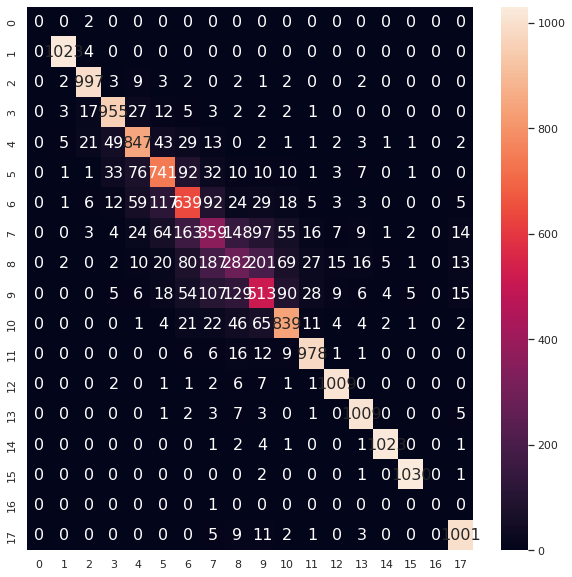

ROC AUC: 0.960451


In [ ]:
# Additional performance metrics
# F1 score = weighted average of percision and recall
f1score = f1_score(y_test, pred, average='weighted')
print("F1 score for meta Model", f1score)

# precision tp / (tp + fp)
precision = precision_score(y_test, pred, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, pred, average='weighted')
print('Recall: %f' % recall)

matthews_corrcoef_score = matthews_corrcoef(y_test, pred)
print("Matthews Coefficient Score", matthews_corrcoef_score)

matrix = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(matrix, range(18), range(18))
plt.figure(figsize=(10,10))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16}) # font size
plt.show()

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print('ROC AUC: %f' % auc)


# Generate Final Predictions


In [ ]:

# train meta model on all training data
model_voting.fit(X_train_resampled, np.array(y_train_resampled).ravel())

0:	learn: 2.8394340	total: 473ms	remaining: 6m 22s
1:	learn: 2.7966778	total: 1s	remaining: 6m 44s
2:	learn: 2.7595299	total: 1.46s	remaining: 6m 33s
3:	learn: 2.7241204	total: 1.94s	remaining: 6m 30s
4:	learn: 2.6939831	total: 2.46s	remaining: 6m 36s
5:	learn: 2.6664005	total: 2.92s	remaining: 6m 31s
6:	learn: 2.6401046	total: 3.38s	remaining: 6m 28s
7:	learn: 2.6166396	total: 3.83s	remaining: 6m 24s
8:	learn: 2.5948306	total: 4.28s	remaining: 6m 20s
9:	learn: 2.5736988	total: 4.72s	remaining: 6m 18s
10:	learn: 2.5547860	total: 5.23s	remaining: 6m 20s
11:	learn: 2.5384038	total: 5.69s	remaining: 6m 18s
12:	learn: 2.5207018	total: 6.22s	remaining: 6m 21s
13:	learn: 2.5060141	total: 6.66s	remaining: 6m 18s
14:	learn: 2.4901265	total: 7.16s	remaining: 6m 19s
15:	learn: 2.4770720	total: 7.64s	remaining: 6m 18s
16:	learn: 2.4636885	total: 8.13s	remaining: 6m 19s
17:	learn: 2.4454952	total: 8.62s	remaining: 6m 19s
18:	learn: 2.4331057	total: 9.08s	remaining: 6m 18s
19:	learn: 2.4174939	tota

VotingClassifier(estimators=[('xgboost',
                              XGBClassifier(colsample_bytree=0.7924098400793136,
                                            eta=0.001, gamma=4.965400030515824,
                                            max_depth=14, min_child_weight=0,
                                            n_estimators=50, reg_alpha=40,
                                            reg_lambda=0.7173099655368509,
                                            subsample=1.0)),
                             ('lgbm',
                              LGBMClassifier(colsample_bytree=0.3275662333985147,
                                             gamma=0.1,
                                             learning_rate=0.10289843447873394,
                                             max_depth=8, min_child_weight=6,
                                             n_estimators=124, num_leaves=42,
                                             reg_alpha=1.5,
                                     

In [ ]:
# load testing data
#X_test_df =  pd.read_excel(r'/content/drive/MyDrive/AI Case Study Data/general_industries_df_case_competition_scrambled_test_clean.xlsx', sheet_name='Data')
#X_Test_final = np.load('/content/drive/MyDrive/AI Case Study Data/XXXXXXXXXXXXXXX.npy')
X_Test_final = pd.read_csv('/content/drive/MyDrive/AI Case Study Data/Final_X_test_general.csv')


In [ ]:
X_Test_final

,Unnamed: 0,ACIDTESTRATIO_Y0,ACIDTESTRATIO_Y1,ACIDTESTRATIO_Y2,ACIDTESTRATIO_Y3,ARTurnover_Y0,ARTurnover_Y1,ARTurnover_Y2,ARTurnover_Y3,ASSETTURNOVER_Y0,ASSETTURNOVER_Y1,ASSETTURNOVER_Y2,ASSETTURNOVER_Y3,CA2CL_Y0,CA2CL_Y1,CA2CL_Y2,CA2CL_Y3,CAPITALIZATION_Y0,CAPITALIZATION_Y1,CAPITALIZATION_Y2,CAPITALIZATION_Y3,CAPITALIZATION_YOYGrowth,CASH2ASSET_Y0,CASH2ASSET_Y1,CASH2ASSET_Y2,CASH2ASSET_Y3,CASH2DEBT_Y0,CASH2DEBT_Y1,CASH2DEBT_Y2,CASH2DEBT_Y3,CCC_Y0,CCC_Y1,CCC_Y2,CCC_Y3,CCE_Y0,CCE_Y1,CCE_Y2,CCE_Y3,COGS_Y0,COGS_Y1,...,TOTALASSET_Y0,TOTALASSET_Y1,TOTALASSET_Y2,TOTALASSET_Y3,TOTALASSET_YOYGrowth,TOTALDEBT_Y0,TOTALDEBT_Y1,TOTALDEBT_Y2,TOTALDEBT_Y3,TOTALDEBT_YOYGrowth,TOTALEQUITY_Y0,TOTALEQUITY_Y1,TOTALEQUITY_Y2,TOTALEQUITY_Y3,TOTALNETWORTH_Y0,TOTALNETWORTH_Y1,TOTALNETWORTH_Y2,TOTALNETWORTH_Y3,TOTALREVENUE_Y0,TOTALREVENUE_Y1,TOTALREVENUE_Y2,TOTALREVENUE_Y3,TOTALREVENUE_YOYGrowth,TOTINTEXP_Y0,TOTINTEXP_Y1,TOTINTEXP_Y2,TOTINTEXP_Y3,TotalAssetBINS,payableDAYS_Y0,payableDAYS_Y1,payableDAYS_Y2,payableDAYS_Y3,receivabledays_Y0,receivabledays_Y1,receivabledays_Y2,receivabledays_Y3,tangibleNetWorth_Y0,tangibleNetWorth_Y1,tangibleNetWorth_Y2,tangibleNetWorth_Y3
0,0,1.547594,2.101018,-415.483877,-504.343759,-0.028469,-0.037013,11.025202,6.282257,-0.008867,-0.015238,-0.005845,-0.017880,0.641994,0.723749,0.643680,1.086216,-0.015026,-0.017387,-0.014574,-0.019108,-0.060024,0.902300,0.932113,0.882061,0.963441,0.800358,0.875738,0.858179,0.750779,0.079139,0.095804,2.187775,2.578876,-0.014821,-0.016979,-0.014604,-0.014087,33.641102,37.245971,...,-0.016426,-0.018215,-0.016556,-0.014622,0.044766,-0.018518,-0.019388,-0.017017,-0.018763,0.000470,-0.015751,-0.017646,-0.014488,-0.019839,-0.014460,-0.016824,-0.013618,-0.019337,-0.020384,-0.020721,-0.017215,-0.020672,0.006726,-0.024488,-0.024192,-0.025532,-0.022064,2,-0.278005,-0.277826,3.766682,3.754901,-0.028506,-0.011433,-0.015314,0.437588,-0.010034,-0.014055,-0.011042,-0.017209
1,1,1.547521,2.102239,2.248270,-328.408496,-0.028488,-0.036759,-0.045402,4.100246,-0.011570,-0.014742,-0.006591,-0.016092,0.625305,0.716205,0.633796,1.082622,-0.014692,-0.017121,-0.015478,-0.019822,-0.084967,0.898432,0.934739,0.876700,0.966825,0.807176,0.882402,0.855493,0.746624,2.231818,2.222568,1.093342,2.023010,-0.014349,-0.016749,-0.014289,-0.014049,-1.021082,-1.063743,...,-0.015972,-0.017919,-0.016298,-0.014531,0.037453,-0.017777,-0.018982,-0.016702,-0.018817,-0.013119,-0.015295,-0.017397,-0.015767,-0.020230,-0.014161,-0.016601,-0.015048,-0.019720,-0.019747,-0.020293,-0.019961,-0.018853,0.016166,-0.025584,-0.024328,-0.024643,-0.022002,3,3.515693,3.708277,3.869545,3.793046,-0.017711,-0.008997,-0.907141,0.078801,-0.009632,-0.013811,-0.011139,-0.017428
2,2,-0.582403,-1.059957,-0.804495,4.942119,-0.028389,-0.036774,-0.045235,-0.046555,-0.009360,-0.012840,-0.046109,-0.018052,-0.074786,-0.266948,-0.100417,1.088798,0.159908,0.096975,0.142764,0.003579,13.073547,-0.054346,-0.137772,-0.026206,1.528156,-0.023282,-0.057385,-0.012827,-0.314887,0.080735,0.098361,0.779653,0.820635,-0.009548,-0.014575,-0.003637,-0.013107,34.818016,37.164077,...,0.175682,0.105793,0.138784,-0.008577,-5.586012,0.410087,0.253990,0.283531,0.041624,2.107355,0.087310,0.057500,0.088702,-0.022605,0.078787,0.050995,0.091920,-0.021344,0.101226,0.046250,0.056929,-0.015435,-1.229118,0.937031,0.606529,0.630194,0.083466,4,-0.277978,-0.277897,-0.269272,-0.264266,-0.026919,-0.008918,0.675840,0.728683,0.018778,0.009890,0.013423,-0.020161
3,3,1.871354,2.349633,2.600485,4.929232,-0.028591,-0.036370,-0.044936,-0.046781,-0.010387,-0.015232,-0.024739,0.027345,0.563837,0.700158,0.606382,1.074304,-0.012719,-0.015853,-0.013718,-0.019617,-0.114257,1.067983,1.017973,0.999467,0.982661,0.867125,0.918357,0.955157,0.746138,0.104878,0.095671,-0.695377,-0.835238,-0.014703,-0.016714,-0.014482,-0.014093,11.194006,25.358252,...,-0.013767,-0.016419,-0.014489,-0.014341,-0.005994,-0.016956,-0.018200,-0.015162,-0.018887,-0.021727,-0.013324,-0.015910,-0.014640,-0.021256,-0.011693,-0.015119,-0.013140,

In [ ]:
X_Test_final = X_Test_final.drop(columns='Unnamed: 0').to_numpy()

In [ ]:
# generate preditions
y_test_pred_final = model_voting.predict(X_Test_final)

In [ ]:
np.bincount(y_test_pred_final)

array([    0,     5,    39,    30,    21,     9,     8,   706, 11381])

In [ ]:
# save predictions to a csv file
np.savetxt("general_final_ig.csv", y_test_pred_final, delimiter=",")


In [ ]:
# train LGBM model on all training data
classifiers[1].fit(X_train_resampled, np.array(y_train_resampled).ravel())


In [ ]:
y_test_pred_final_LGBM = classifiers[1].predict(X_Test_final)


In [ ]:
np.bincount(y_test_pred_final_LGBM)

array([    0,     4,   109,   101,    46,    23,   373,   912, 10627,
           4])